# 1 — Install dependencies

In [ ]:
!pip install -q ultralytics deep_sort_realtime opencv-python-headless tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 91.9 MB/s eta 0:00:00


# 2 — Import libraries

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 3 — Download or upload your video

In [ ]:
!wget -O people.mp4 https://media.roboflow.com/supervision/video-examples/people-walking.mp4


--2025-10-15 07:39:42--  https://media.roboflow.com/supervision/video-examples/people-walking.mp4
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7606633 (7.3M) [video/mp4]
Saving to: ‘people.mp4’

people.mp4          100%[===================>]   7.25M  7.94MB/s    in 0.9s    

2025-10-15 07:39:44 (7.94 MB/s) - ‘people.mp4’ saved [7606633/7606633]



# 4 — Initialize model and tracker

In [ ]:
# Load YOLOv8 pretrained model (person detection)
model = YOLO('yolov8n.pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30, n_init=2, max_cosine_distance=0.3)


# 5 — Define counting lines and counters

In [ ]:
# Define lines for IN and OUT counting
line_in_y = 200     # upper line
line_out_y = 400    # lower line

in_count = 0
out_count = 0

# To store last positions of each tracked object
track_history = {}

# For heatmap
heatmap = None


# 6 — Define helper functions

In [ ]:
def draw_lines(frame):
    """Draw entry and exit lines."""
    cv2.line(frame, (0, line_in_y), (frame.shape[1], line_in_y), (0, 255, 0), 2)
    cv2.line(frame, (0, line_out_y), (frame.shape[1], line_out_y), (0, 0, 255), 2)
    return frame


# 7 — Process video frame-by-frame

In [ ]:
video_path = 'people.mp4'
cap = cv2.VideoCapture(video_path)

# Output video writer
out = cv2.VideoWriter(
    'output_people_tracking.mp4',
    cv2.VideoWriter_fourcc(*'mp4v'),
    20,
    (int(cap.get(3)), int(cap.get(4)))
)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=total_frames, desc="Processing frames")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(frame, imgsz=640, conf=0.35, verbose=False)
    res = results[0]

    # Build detections for DeepSORT
    dets = []
    if hasattr(res, "boxes") and res.boxes is not None:
        for box in res.boxes:
            cls = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else 0
            if cls != 0:
                continue  # only person
            xyxy = box.xyxy.cpu().numpy()[0]
            conf = float(box.conf.cpu().numpy()[0])
            x1, y1, x2, y2 = map(int, xyxy.tolist())
            w, h = x2 - x1, y2 - y1
            dets.append(([x1, y1, w, h], conf, 'person'))

    # Update DeepSORT tracker
    tracks = tracker.update_tracks(dets, frame=frame)

    # Initialize heatmap
    if heatmap is None:
        heatmap = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32)

    # Draw lines
    draw_lines(frame)

    # Loop through tracks
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        obj_id = track.track_id
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)

        # Draw bounding boxes
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
        cv2.putText(frame, f'ID {obj_id}', (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

        # Heatmap accumulation
        heatmap[cy-2:cy+2, cx-2:cx+2] += 1

        # Count logic
        prev_y = track_history.get(obj_id, cy)
        if prev_y < line_in_y and cy >= line_in_y:
            in_count += 1
        elif prev_y > line_out_y and cy <= line_out_y:
            out_count += 1

        track_history[obj_id] = cy

    # Display counts
    cv2.putText(frame, f"IN: {in_count}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(frame, f"OUT: {out_count}", (20, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    out.write(frame)
    pbar.update(1)

cap.release()
out.release()
pbar.close()


Processing frames: 100%|██████████| 341/341 [07:20<00:00,  1.29s/it]


# 8 — Generate and show the final heatmap

✅ Heatmap saved as people_heatmap.png


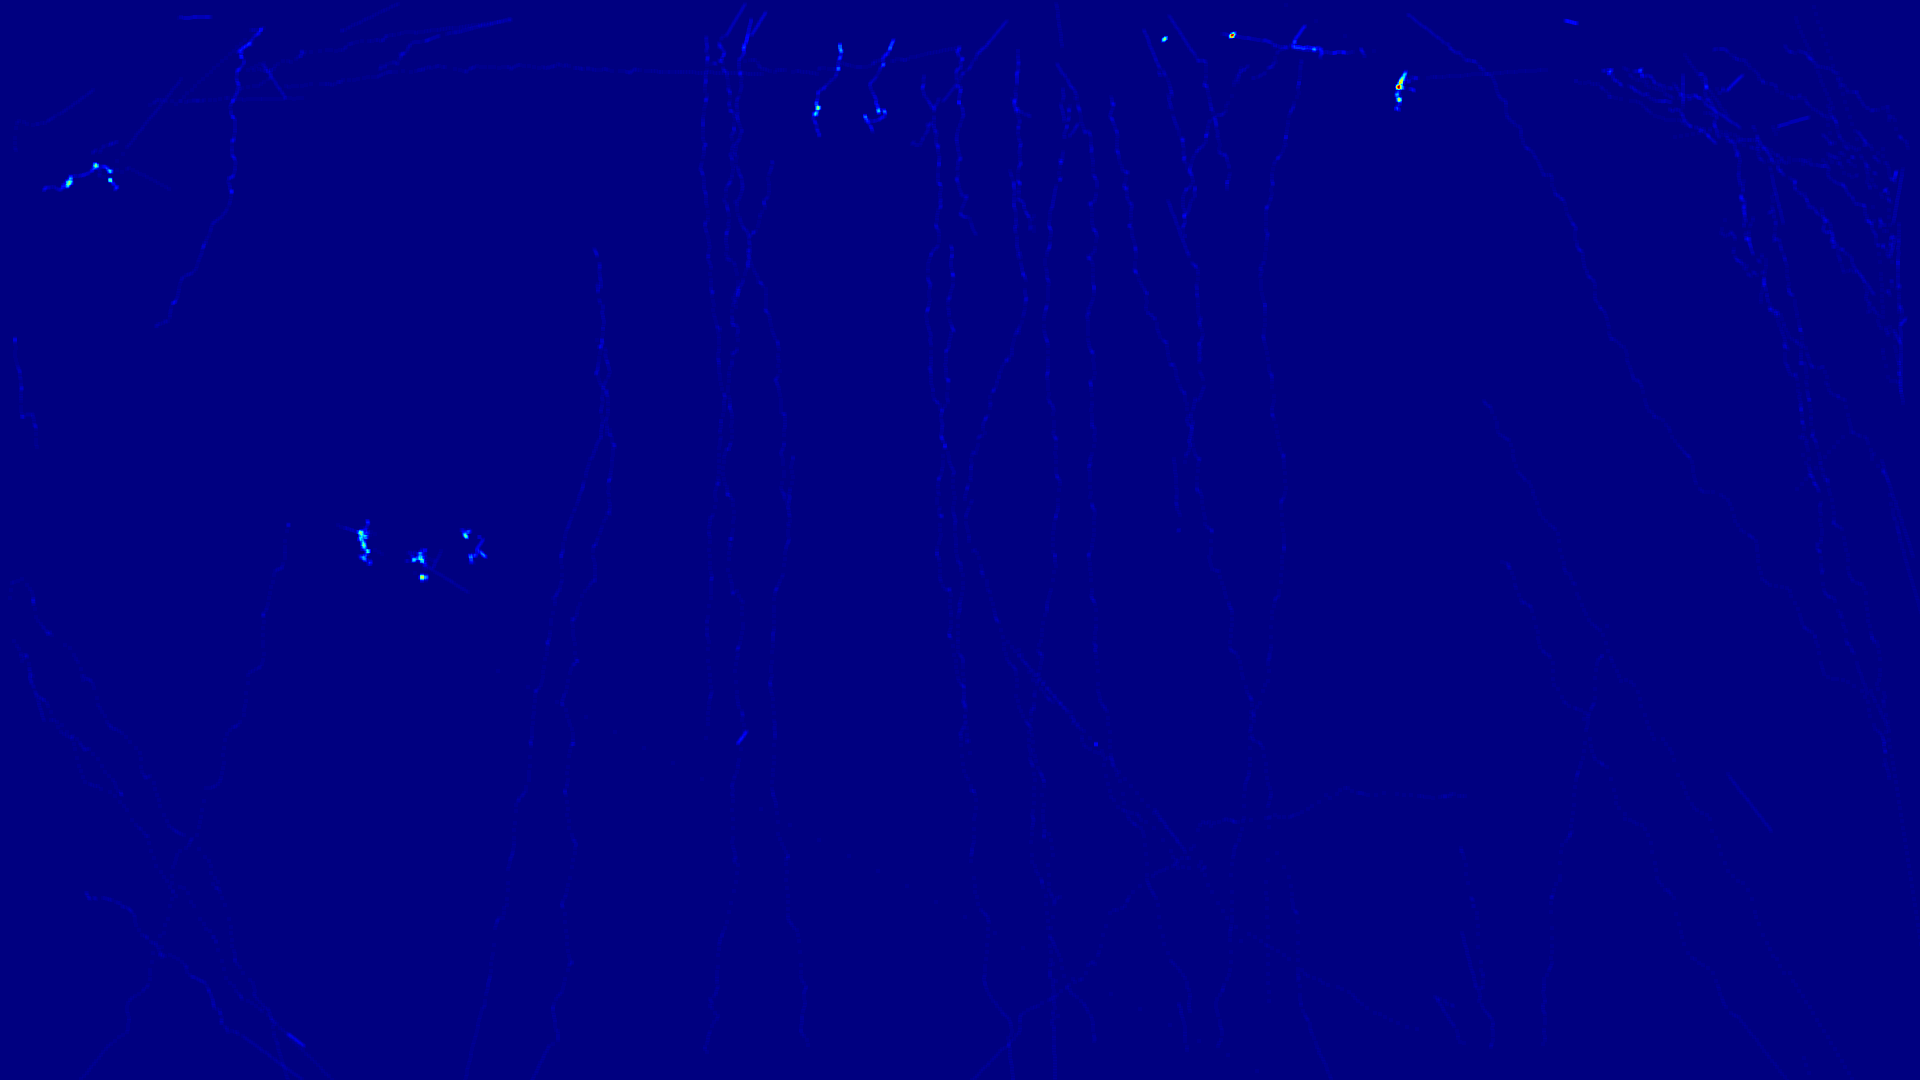

In [ ]:
# Normalize and colorize the heatmap
heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap_color = cv2.applyColorMap(heatmap_norm.astype(np.uint8), cv2.COLORMAP_JET)

# Save the heatmap
cv2.imwrite("people_heatmap.png", heatmap_color)
print("✅ Heatmap saved as people_heatmap.png")

# Display heatmap
from google.colab.patches import cv2_imshow
cv2_imshow(heatmap_color)


# 9 — Final Results

In [ ]:
print(f"✅ Total IN: {in_count}")
print(f"✅ Total OUT: {out_count}")
print("🎥 Output video saved as: output_people_tracking.mp4")


✅ Total IN: 15
✅ Total OUT: 8
🎥 Output video saved as: output_people_tracking.mp4
